In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
%matplotlib inline

# Data loading

In [2]:
#Loading train and test data (test set for competition will be called evaluate)
train = pd.read_csv('train.csv', index_col = 'PassengerId')
test = pd.read_csv('test.csv', index_col = 'PassengerId')

In [3]:
#appending both sets to be sure, that made changes whould be the same
full = train.append(test, ignore_index=False, sort = False)

In [4]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Features engineering

In [8]:
#there is lack of values in two variables, that I want to use (Age, Embarked and Fare)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Survived    891 non-null float64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [9]:
#change of non-numerical features into numerical with dummy variables and factorization
Embarked_dummy = pd.get_dummies(full['Embarked'], drop_first=True, prefix = 'Embarked', dummy_na=True)
full = full.join(Embarked_dummy)
full['Sex'] = full['Sex'].factorize()[0]

In [10]:
#I decided to fill NaNs of Age and Fares with means. Analysis showed highest correlation with Pclass category values, 
#so I fill  these NaNs separately for each class:
train.corr()['Age'].sort_values(ascending = False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

In [11]:
train.corr()['Fare'].sort_values(ascending = False)

Fare        1.000000
Survived    0.257307
Parch       0.216225
SibSp       0.159651
Age         0.096067
Pclass     -0.549500
Name: Fare, dtype: float64

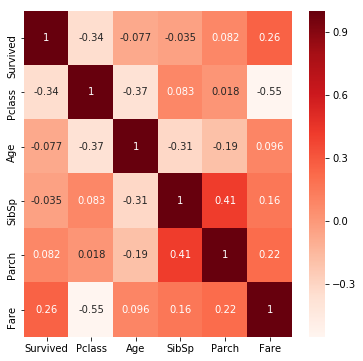

In [54]:
#looking for correlations among variables
plt.figure(figsize = (6,6))
sns.heatmap(train.corr(), cmap = 'Reds', annot=True)

In [12]:
class1 = full[full['Pclass'] == 1].copy()
class1['Age'] = class1['Age'].fillna(full.groupby(by = 'Pclass').mean()['Age'][1])

class2 = full[full['Pclass'] == 2].copy()
class2['Age'] = class2['Age'].fillna(full.groupby(by = 'Pclass').mean()['Age'][2])

class3 = full[full['Pclass'] == 3].copy()
class3['Age'] = class3['Age'].fillna(full.groupby(by = 'Pclass').mean()['Age'][3])

full = class1.append(class2).append(class3).sort_index()

In [13]:
f_class1 = full[full['Pclass'] == 1].copy()
f_class1['Fare'] = f_class1['Fare'].fillna(full.groupby(by = 'Pclass').mean()['Fare'][1])

f_class2 = full[full['Pclass'] == 2].copy()
f_class2['Fare'] = f_class2['Fare'].fillna(full.groupby(by = 'Pclass').mean()['Fare'][2])

f_class3 = full[full['Pclass'] == 3].copy()
f_class3['Fare'] = f_class3['Fare'].fillna(full.groupby(by = 'Pclass').mean()['Fare'][3])

full = f_class1.append(f_class2).append(f_class3).sort_index()

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


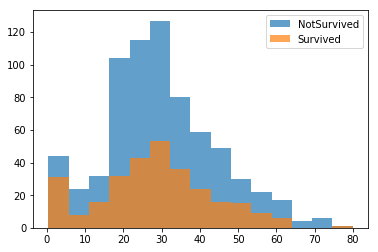

In [53]:
plt.hist(train['Age'], alpha = 0.7, label = 'NotSurvived', bins = 15)
plt.hist(train[train['Survived'] == 1]['Age'], alpha = 0.7, label = 'Survived', bins = 15)
plt.legend()

In [14]:
#above chart shows, that there is a limit age, above which chances of surviving don't grow
#below I'm trying to calculate this limit age
ages = []
corr = []

for age in range(1, 80):
    Child = np.where(train['Age'] < age, 1,0)
    a = np.corrcoef(train['Survived'], Child)
    corr.append(a[1][0])
    ages.append(age)
    Series = pd.Series(corr, ages)
    child_age = Series.idxmax()
child_age

7

In [15]:
full['Child'] = np.where(full['Age'] < child_age, 1,0)

In [16]:
#division for training and evaluating sets
full = full.drop(['Name', 'Ticket', 'Cabin', 'Age', 'Embarked'], axis = 1)
data = full[full['Survived'].isna() == False]
evaluate = full[full['Survived'].isna() == True].drop(labels = 'Survived', axis = 1)

In [17]:
#creating X and y sets
X = data.drop(['Survived'], axis = 1)
y = data['Survived']

In [18]:
#division of sets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Decision Tree with GridSearchCV

In [19]:
#using GridSearchCV module to find best hiperparameters for Decision Tree with usage of Cross Validation
tree_param_grid = {'max_depth': range(1, 5),
             'min_samples_leaf': range(1, 8),
             'min_samples_split': range(2, 8),
             'criterion': ['gini', 'entropy']}
tree_estimator = DecisionTreeClassifier(random_state = 1)
tree_grid = GridSearchCV(param_grid = tree_param_grid, estimator = tree_estimator, cv = 4, n_jobs=4)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(1, 8), 'min_samples_split': range(2, 8), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
#model scoring (the best to choose the bes model, as accuracy score will be used in final)
tree_grid_score = tree_grid.score(X_test, y_test)
tree_grid_score

0.8044692737430168

In [21]:
#checking the best hiperparameters
best_params = tree_grid.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [49]:
#For this model I'm checking also other types of metrics
prediction = tree_grid.predict(X_test)

print(confusion_matrix(y_test, prediction))

print(classification_report(y_test,prediction))

[[95 11]
 [24 49]]
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       106
         1.0       0.82      0.67      0.74        73

   micro avg       0.80      0.80      0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



# Random forest

In [25]:
#Random Forest training using the best hiperparameters from GridSearchCV for Decision Tree
max_features = int(np.ceil(np.sqrt(len(X_train.columns))))
forest = RandomForestClassifier(criterion = best_params['criterion'], bootstrap=True, max_features=max_features,
                               max_depth= best_params['max_depth'],
                               min_samples_leaf = best_params['min_samples_leaf'],
                               min_samples_split = best_params['min_samples_split'],
                               n_jobs = 4, n_estimators = 500)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
forest_score = forest.score(X_test, y_test)
forest_score

0.776536312849162

In [27]:
#checking importance of used variables
feature_importances = pd.Series(forest.feature_importances_, X_train.columns).sort_values(ascending = False)
feature_importances

Sex             0.480293
Pclass          0.195096
Fare            0.166009
Child           0.054002
SibSp           0.041787
Parch           0.033781
Embarked_S      0.019721
Embarked_Q      0.008918
Embarked_nan    0.000394
dtype: float64

Text(0.5, 1.0, 'Feature Importances')

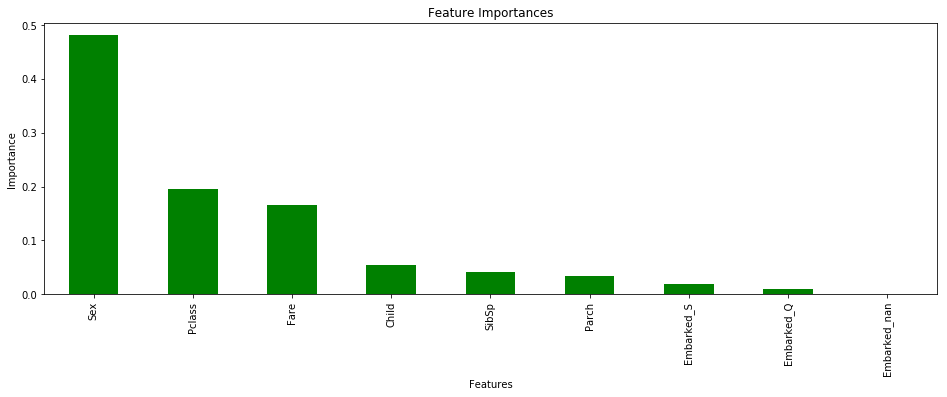

In [28]:
feature_importances.plot(kind = 'bar', figsize=(16, 5), color='Green')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')

# Logistic Regression

In [29]:
#Classification with Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
logistic_score = logistic.score(X_test, y_test)
logistic_score

0.7988826815642458

## Support Vector Machine

In [32]:
#Using GridSearch to find the best hiperparameters for Support Vector Machine
svm_param_grid = {'C': [10**c/5 for c in range(-2, 5)],
                 'gamma': [10**c/5 for c in range(-6, 1)]}
svm_estimator = SVC(random_state=1) 
svm_grid = GridSearchCV(param_grid=svm_param_grid,
                       estimator=svm_estimator,
                       n_jobs=4)

In [52]:
svm_grid.fit(X_train, y_train);

C:\Users\Mateusz Bujalski\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [35]:
svm_grid_score = svm_grid.score(X_test, y_test)
svm_grid_score

0.770949720670391

In [36]:
svm_grid.best_params_

{'C': 2000.0, 'gamma': 0.0002}

## DummyClasifier

In [37]:
#comparing obtained scores with score from Dummy Classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [38]:
dummy.score(X_test, y_test)

0.5307262569832403

## Predictions for test data

In [39]:
#collecting scores of all created models and choosing the highest
scores = pd.Series({'tree_grid': tree_grid_score,
'forest': forest_score,
'svm_grid': svm_grid_score,
'logistic': logistic_score})
scores.sort_values(ascending = False)

tree_grid    0.804469
logistic     0.798883
forest       0.776536
svm_grid     0.770950
dtype: float64

In [40]:
#creating file for submission using model with the best score
predict = logistic.predict(X = evaluate).astype(int)

In [41]:
results = pd.DataFrame({'PassengerId': evaluate.index,
                        'Survived': predict})

In [42]:
results = results.set_index(keys = 'PassengerId')

In [43]:
results.to_csv('submission.csv')